In [1]:
# Import modules
from bokeh import layouts
import pandas as pd 
from collections import Counter 
import numpy as np 
import itertools 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string 

plt.style.use('seaborn-darkgrid')

import warnings 
warnings.filterwarnings("ignore")

## Wordcloud libraries and utilities 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from IPython.display import display

# Word Count Visualization Libraries 
import nltk
from nltk.util import ngrams
import emoji 
import re 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from bs4 import BeautifulSoup 
import gensim 
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec 
import multiprocessing 
import preprocessor as tp

# Bokeh 
from bokeh.io import show, output_notebook, curdoc
from bokeh.models import ColumnDataSource, Panel, Tabs, FactorRange
from bokeh.models import HoverTool 
from bokeh.plotting import figure 
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
import bokeh.layouts as layouts 
import bokeh.models.widgets as widgets 
from bokeh.transform import factor_cmap, dodge 
output_notebook() 

# Plotly 
import plotly.express as px 
import plotly.graph_objects as go 


Loading BokehJS ...

In [2]:
# Read the dataframe
df = pd.read_csv('../data/processed/tanishq_data_labelled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9427 non-null   int64  
 1   Tweet       9427 non-null   object 
 2   sentiment   2203 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 221.1+ KB


In [3]:
df['clean_tweet'] = df['Tweet'].apply(lambda x: re.sub(r'#(\w+)', r'\1', x))
# Removal of @mentions, RT's, HTTPs etc. 
tp.set_options(tp.OPT.URL, tp.OPT.EMOJI, tp.OPT.MENTION, tp.OPT.NUMBER) 
df['clean_tweet'] = df['clean_tweet'].apply(tp.clean).apply(lambda x: x.lower())
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('[%s]' %re.escape(string.punctuation), '', x))

In [4]:
df

,Unnamed: 0,Tweet,sentiment,clean_tweet
0,0,I hv been disappointed by the fact that Tanish...,4.0,i hv been disappointed by the fact that tanish...
1,1,@TanishqJewelry @RNTata2000 #EkatvamByTanishq...,4.0,ekatvambytanishq thank you so much for beautif...
2,2,#EkatvamByTanishq @tanishq #HappyDiwali @sayan...,4.0,ekatvambytanishq happydiwali a wonderful ad an...
3,3,Hope @TanishqJewelry wishes d same on #NewYear...,0.0,hope wishes d same on newyearseve have u ever ...
4,4,@Ramesh_hjs @RituRathaur @HinduJagrutiOrg @rah...,10.0,this is called tanishqekatvam by ms r united n...
...,...,...,...,...
9422,9422,@TanishqJewelry @AlayaF___ @NimratOfficial @Ne...,NaN,boycotttanishq
9423,9423,Why every time same mistake #boycotttanishq,NaN,why every time same mistake boycotttanishq
9424,9424,#boycotttanishq stop giving gyaan to us... Sto...,NaN,boycotttanishq stop giving gyaan to us stop ki...
9425,9425,"So Diwali is only buying gold, ""nice"" clothes,...",NaN,so diwali is only buying gold nice clothes par...


In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
df['clean_tweet_token'] = df['clean_tweet'].apply(lemmatizer.lemmatize).apply(tokenizer.tokenize)
df['clean_tweet_token'] = df['clean_tweet_token'].str.join(' ')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mamu867/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mamu867/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
words_1 = "".join(df['clean_tweet'])

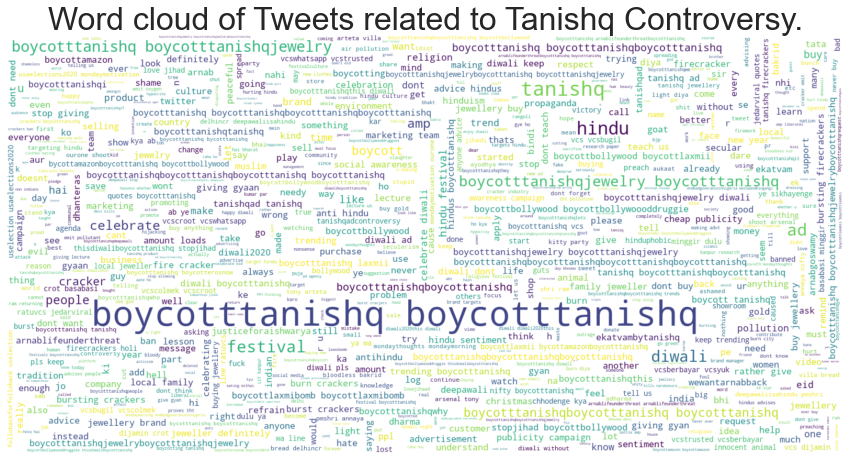

In [7]:
# Without segmentations
wcloud_1 = WordCloud(
    max_words=800,
    width=1600,
    height=800,
    background_color='white',
    stopwords=stopwords,
).generate(words_1)

wcloud_1.generate_from_frequencies
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.title("Word cloud of Tweets related to Tanishq Controversy.", FontSize=32)
plt.imshow(wcloud_1, interpolation="bilinear")
plt.show()

In [8]:
# With segmentation
from ekphrasis.classes.segmenter import Segmenter
seg = Segmenter(corpus="Twitter") 

df["clean_tweet_segmented"] = df["clean_tweet"].apply(lambda x: [seg.segment(i) for i in x.split()])


Reading Twitter - 1grams ...
Reading Twitter - 2grams ...


In [9]:
df['clean_tweet_segmented'] = df['clean_tweet_segmented'].apply(lambda x: ' '.join(x))

In [10]:
df['clean_tweet_segmented']

0       i hv been disappointed by the fact that tanish...
1       ek at vam by tanishq thank you so much for bea...
2       ek at vam by tanishq happy diwali a wonderful ...
3       hope wishes d same on new years eve have u eve...
4       this is called tan ishq ek atv am by ms r unit...
                              ...                        
9422                                      boycott tanishq
9423          why every time same mistake boycott tanishq
9424    boycott tanishq stop giving gyaan to us stop k...
9425    so diwali is only buying gold nice clothes par...
9426    nothing relating to our culture here again you...
Name: clean_tweet_segmented, Length: 9427, dtype: object

In [11]:
words_2 = " ".join(df['clean_tweet_segmented'])

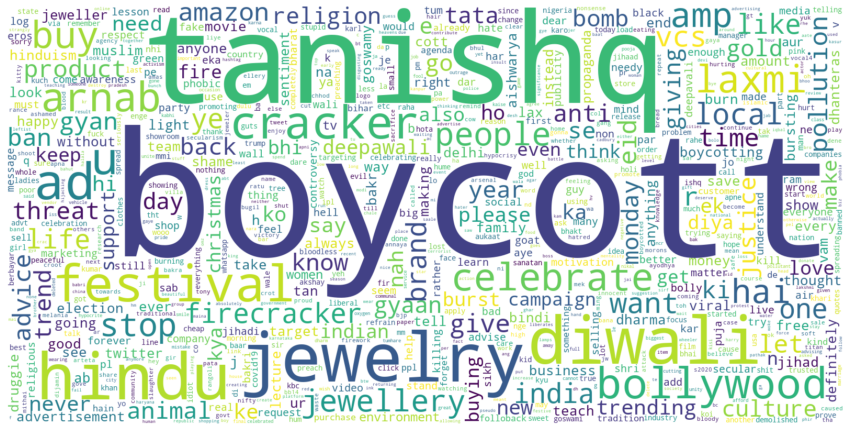

In [12]:
# Without segmentations
wcloud_2 = WordCloud(
    max_words=800,
    width=1600,
    height=800,
    background_color='white',
    stopwords=stopwords,
    collocations=False,
).generate(words_2)

wcloud_1.generate_from_frequencies
plt.figure(figsize=(15, 10))
plt.axis('off')
#plt.title("Word cloud of Tweets related to Tanishq Controversy.", FontSize=32)
plt.imshow(wcloud_2, interpolation="bilinear")
plt.tight_layout()
plt.savefig('../images/wordcloud.png')
plt.show()


In [13]:
counter = Counter(words_2.split(' '))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'boycott'),
  Text(1, 0, 'tanishq'),
  Text(2, 0, 'to'),
  Text(3, 0, 'jewelry'),
  Text(4, 0, 'i'),
  Text(5, 0, 'and'),
  Text(6, 0, 'diwali'),
  Text(7, 0, 'is'),
  Text(8, 0, 'the'),
  Text(9, 0, 'a'),
  Text(10, 0, 'of'),
  Text(11, 0, 'this'),
  Text(12, 0, 'on'),
  Text(13, 0, 'you'),
  Text(14, 0, 'in'),
  Text(15, 0, 'hindu'),
  Text(16, 0, 'for'),
  Text(17, 0, 'it'),
  Text(18, 0, 't'),
  Text(19, 0, 'not'),
  Text(20, 0, 'we'),
  Text(21, 0, 'are'),
  Text(22, 0, 'your'),
  Text(23, 0, 'ad'),
  Text(24, 0, 's')])

findfont: Font family ['Monaco'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Monaco'] not found. Falling back to DejaVu Sans.


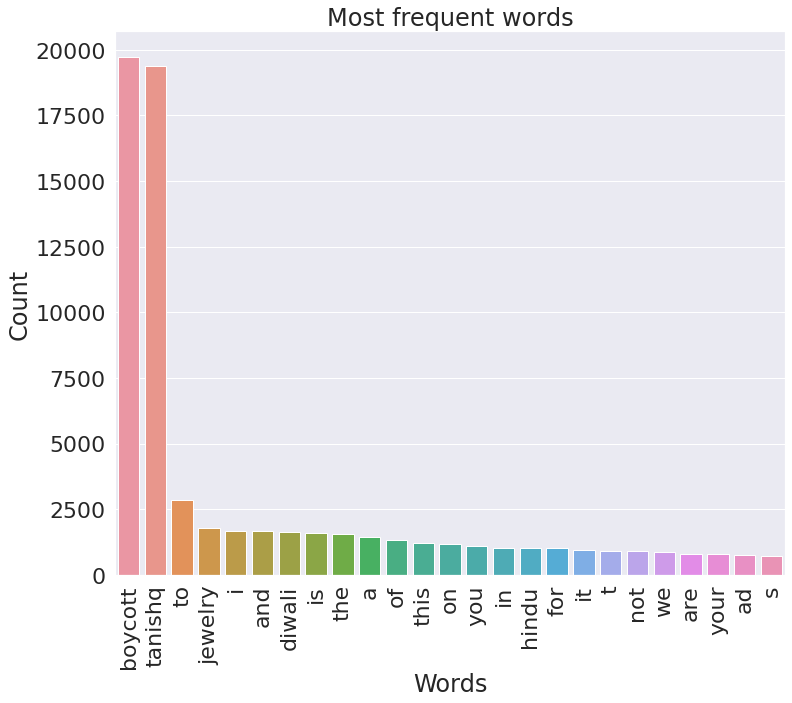

In [14]:
sns.set(style='darkgrid', font_scale=2, font='Monaco')

plt.figure(figsize=(12, 10))
mc_df = pd.DataFrame(counter.most_common(25))
ax = sns.barplot(x=0, y=1, data=mc_df)
ax.set(xlabel = 'Words', ylabel='Count', title='Most frequent words')
plt.xticks(rotation=90)

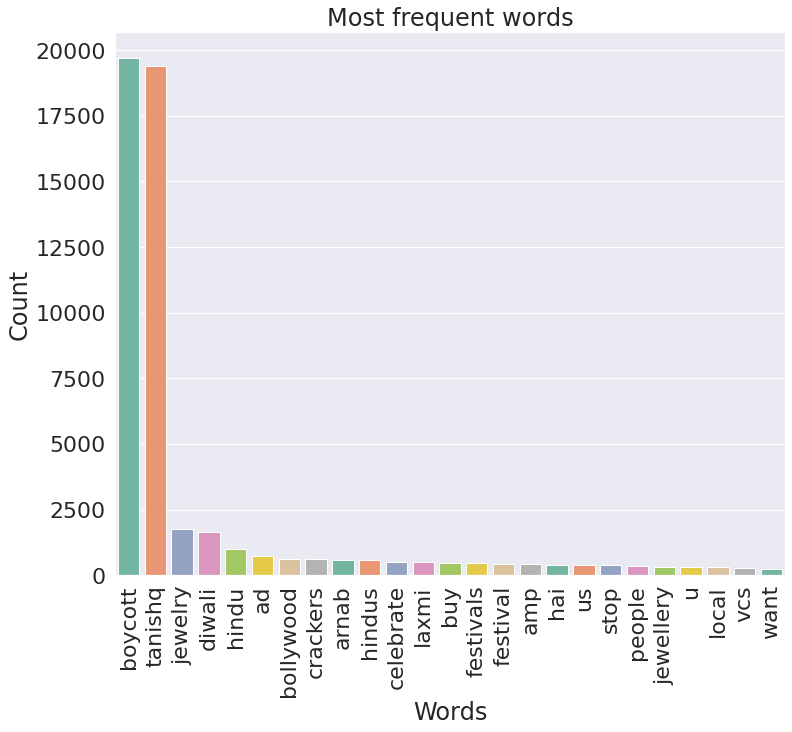

In [15]:
counter = Counter([i for i in words_2.split(' ') if i not in stopwords])
sns.set(style='darkgrid', font_scale=2, font='Monaco')

plt.figure(figsize=(12, 10))
mc_df = pd.DataFrame(counter.most_common(25))
ax = sns.barplot(x=0, y=1, data=mc_df, palette="Set2")
ax.set(xlabel = 'Words', ylabel='Count', title='Most frequent words')
plt.xticks(rotation=90)
plt.savefig('../images/word_frequency.png')

In [16]:
mc_df.columns = ['word', 'count']
fig = px.bar(mc_df, x='word', y='count', color='count', color_continuous_scale=px.colors.qualitative.Antique_r)
fig.update_layout(coloraxis_showscale=False)
fig.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, "('boycott', 'tanishq')"),
  Text(1, 0, "('tanishq', 'boycott')"),
  Text(2, 0, "('tanishq', 'jewelry')"),
  Text(3, 0, "('jewelry', 'boycott')"),
  Text(4, 0, "('boycott', 'bollywood')"),
  Text(5, 0, "('bollywood', 'boycott')"),
  Text(6, 0, "('boycott', 'laxmi')"),
  Text(7, 0, "('tanishq', 'tanishq')"),
  Text(8, 0, "('diwali', 'boycott')"),
  Text(9, 0, "('tanishq', 'diwali')"),
  Text(10, 0, "('tanishq', 'ad')"),
  Text(11, 0, "('arnab', 'life')"),
  Text(12, 0, "('life', 'threat')"),
  Text(13, 0, "('celebrate', 'diwali')"),
  Text(14, 0, "('amazon', 'boycott')"),
  Text(15, 0, "('laxmi', 'boycott')"),
  Text(16, 0, "('boycott', 'amazon')"),
  Text(17, 0, "('hindu', 'festivals')"),
  Text(18, 0, "('anti', 'hindu')"),
  Text(19, 0, "('boycott', 'boycott')"),
  Text(20, 0, "('diwali', '2020')"),
  Text(21, 0, "('bomb', 'boycott')"),
  Text(22, 0, "('ta

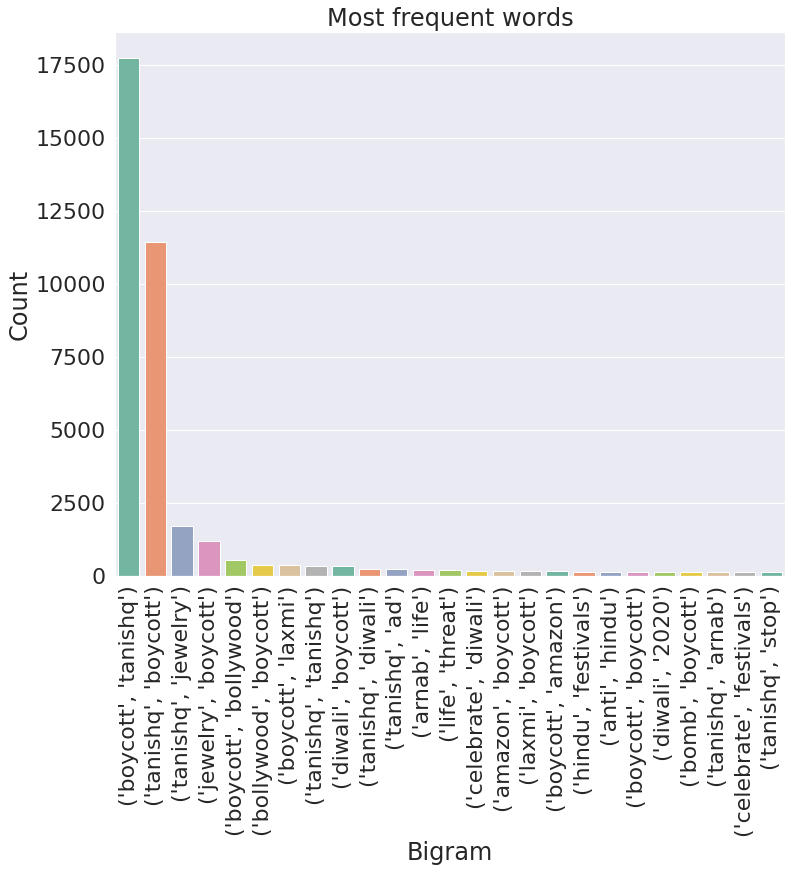

In [17]:
# Bigram plot
counter_bigram = Counter(list(ngrams([i for i in words_2.split(' ') if i not in stopwords], 2)))
sns.set(style='darkgrid', font_scale=2, font='Monaco')

plt.figure(figsize=(12, 10))
mc_bg_df = pd.DataFrame(counter_bigram.most_common(25))
mc_bg_df.columns = ['bigram', 'count']
ax = sns.barplot(x='bigram', y='count', data=mc_bg_df, palette="Set2")
ax.set(xlabel = 'Bigram', ylabel='Count', title='Most frequent words')
plt.xticks(rotation=90)

In [20]:
mc_bg_df['bigram'] = mc_bg_df['bigram'].apply(lambda x: ' '.join(x))
fig = px.bar(mc_bg_df, x='bigram', y='count', color='count', color_continuous_scale=px.colors.qualitative.Antique_r)
fig.update_layout(coloraxis_showscale=False)
fig.show()
fig.write_image("../images/bigram_frequency.png")

In [19]:
# Word2Vec analysis
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split(' '))
w2vec = Word2Vec(tokenized_tweet, size=200, window=2, min_count=2, sg=1, seed=42)
w2vec.train(tokenized_tweet, total_examples=len(tokenized_tweet), epochs=50)

(4173268, 5861850)

In [20]:
w2vec.wv.most_similar('tanishq', topn=10)

[('nationalgreentribunal', 0.42507755756378174),
 ('tanisha', 0.4134225845336914),
 ('tanishqboycott', 0.41085174679756165),
 ('aukkat', 0.3931131064891815),
 ('uboycotttanishq', 0.38881826400756836),
 ('nikalna', 0.38558951020240784),
 ('m', 0.3829406201839447),
 ('themboycotttanishq', 0.3806331157684326),
 ('lenge', 0.37815558910369873),
 ('adshowing', 0.37691542506217957)]

In [21]:
from gensim import downloader
glove = downloader.load('glove-twitter-25')

In [ ]:
glove.most_similar('jewelry')

In [23]:
df.to_csv('../data/processed/tanishq_data_clean_labelled.csv')